In [85]:
# import the libraries

import cv2
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pathlib
import PIL
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


In [86]:
#initializing model constants
INITIAL_LEARINGRATE = .001
EPOCHS = 30
BATCH_SIZE = 32
LENGTH = 224
WIDTH = 224

# Preprocessing the Data

In [88]:
image_path = list(paths.list_images('./DATA'))
data = []
labels = []
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. This will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)


# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)
data.shape

(3091, 224, 224, 3)

In [12]:
#80-20 train test split
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)
trainY = trainY.astype(float)
testY = testY.astype(float)

# InceptionV3 Model

In [93]:
#load the pre-trained inception v3 model and weights making each base layer untrainable
pretrained_model = InceptionV3(input_shape=(LENGTH,WIDTH,3),
                               include_top = False,
                               weights="imagenet")
for layer in pretrained_model.layers:
  layer.trainable = False

In [11]:
#adding head layers for training on the new data with binary output
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, decay = INITIAL_LEARINGRATE/EPOCHS)
x = layers.AveragePooling2D(pool_size=(4,4))(pretrained_model.output)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1,activation='sigmoid')(x)
model = Model(pretrained_model.input, x)
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['acc'])


In [13]:
#Fitting the model to the train data
head = model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30
77/77 [==============================] - 54s 670ms/step - loss: 0.4456 - acc: 0.8101 - val_loss: 0.2685 - val_acc: 0.8882
Epoch 2/30
77/77 [==============================] - 50s 656ms/step - loss: 0.2366 - acc: 0.9041 - val_loss: 0.2185 - val_acc: 0.8997
Epoch 3/30
77/77 [==============================] - 50s 649ms/step - loss: 0.1850 - acc: 0.9328 - val_loss: 0.1883 - val_acc: 0.9227
Epoch 4/30
77/77 [==============================] - 50s 652ms/step - loss: 0.1806 - acc: 0.9311 - val_loss: 0.1756 - val_acc: 0.9326
Epoch 5/30
77/77 [==============================] - 50s 657ms/step - loss: 0.1606 - acc: 0.9418 - val_loss: 0.1654 - val_acc: 0.9260
Epoch 6/30
77/77 [==============================] - 50s 655ms/step - loss: 0.1389 - acc: 0.9480 - val_loss: 0.1661 - val_acc: 0.9359
Epoch 7/30
77/77 [==============================] - 50s 653ms/step - loss: 0.1362 - acc: 0.9496 - val_loss: 0.1708 - val_acc: 0.9326
Epoch 8/30
77/77 [==============================] - 50s 652ms/step - 

In [14]:
predict = model.predict(testX,batch_size=BATCH_SIZE)
predict = np.round(predict)
print(classification_report(testY,predict))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       261
         1.0       0.95      0.93      0.94       358

    accuracy                           0.93       619
   macro avg       0.93      0.93      0.93       619
weighted avg       0.93      0.93      0.93       619



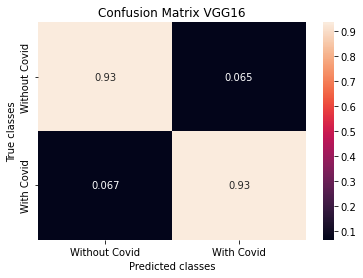

Accuracy:     0.934
Sensitivity:  0.935
Specificity:  0.933


In [15]:

# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY,predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])
# plot confusion matrix
confusionMatrix = confusion_matrix(testY,predict, normalize = 'true')
sns.heatmap(confusionMatrix, annot=True)
plt.title('Confusion Matrix VGG16')
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.yticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.show()

# display the output
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

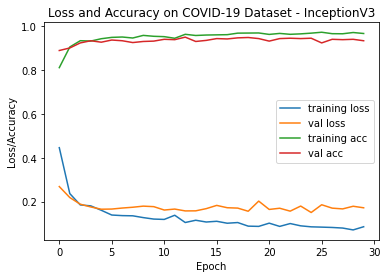

In [17]:
plt.plot(np.arange(0, EPOCHS), head.history['loss'], label='training loss')
plt.plot(np.arange(0, EPOCHS), head.history['val_loss'], label='val loss')
plt.plot(np.arange(0, EPOCHS), head.history['acc'], label='training acc')
plt.plot(np.arange(0, EPOCHS), head.history['val_acc'], label='val acc')
plt.title("Loss and Accuracy on COVID-19 Dataset - InceptionV3")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()